In [1]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.stats import ttest_ind,ttest_rel
from scipy import stats,signal
import matplotlib.pyplot as plt

import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import xarray as xr
import platform
import os
import pandas as pd

import imageio

# add the top level directory to allow it to be imported
import sys
sys.path.append(os.path.split(os.getcwd())[0])
from utilities import plotting_utilities
from utilities import helper_functions

from visual_behavior_research.projects.tbd.session import Session

import visual_behavior_research.projects.tbd.utilities as tbdu
from visual_behavior_research.projects.tbd.Inscopix.series import SeriesCellSet
import visual_behavior_research.plotting as vbp
import visual_behavior_research.plotting.dro_plots as pf
import visual_behavior_research.utilities as vbu
from visual_behavior_research.projects.tbd.Inscopix.pipeline import make_cell_map,plot_cell_map

from visual_behavior_research.projects.tbd.identify_repeat_rois import Repeat_ROI_Identifier

import isx

from visual_behavior.translator.foraging import data_to_change_detection_core
from visual_behavior.translator.core import create_extended_dataframe

pd.set_option('display.max_columns', 500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

/home/dougo/.conda/envs/isxenv/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
window_size=1.5 # number of seconds before/after each stimulus event over which to integrate activity for the purpose of calling a cell 'responsive'
significance_level = 0.05 # level at which to declare a response 'significant'

In [3]:
data_summary = tbdu.get_data_inventory()
data_summary.head()

,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,good_sync,manually_checked,mouse_id,notes,problem,problem_description,processed,running_data,verified_files_present,size(gb),experiment_type,single_cell_plots_made,single_cell_images_made,number_accepted_cells,full_path,recording_date,processing_date,summarized
0,0,//olsenlab1/data/endoscope_imaging,autoreward,2018.03.07_M332849_DoC_day1_autoreward,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,0,M332849,None,1,Not organized into 10 minute chunks,0.0,yes,None,74.790761,change_detection,None,None,NaN,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-07 15:16:45.876000,2018-12-15 15:53:28.984200001-08:00,None
1,1,//olsenlab1/data/endoscope_imaging,static_grating,2018.03.09_M332849_DoC_day2,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,no,no,yes,yes,1,M332849,None,0,None,1.0,yes,None,151.789864,change_detection,True,True,45.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-09 11:27:50.579000,2018-07-25 12:41:22.762362242-07:00,True
2,2,//olsenlab1/data/endoscope_imaging,static_grating,2018.03.13_M332849_DoC_day4,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,1,M332849,None,0,None,1.0,yes,None,134.175156,change_detection,True,True,64.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-13 11:26:45.003000,2018-07-20 10:57:53.647888899-07:00,True
3,3,//olsenlab1/data/endoscope_imaging,natural_images,2018.03.30_M332849_DoC_day9,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,yes,1,M332849,None,0,Note: more dead cells in forcus this day,1.0,yes,None,146.164498,change_detection,True,True,57.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-03-30 13:53:41.511000,2018-07-25 13:48:01.009045124-07:00,True
4,4,//olsenlab1/data/endoscope_imaging,natural_images,2018.04.3_M332849_DoC_day11,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,no,no,yes,no,1,M332849,None,0,None,1.0,yes,None,144.396109,change_detection,True,True,108.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-04-03 13:20:29.101000,2018-07-25 13:59:23.514958143-07:00,True


In [4]:
last_sessions = pd.DataFrame(data_summary.query('good_for_analysis == "yes"').groupby('mouse_id')['recording_date'].max()).reset_index() # last session for every mouse
sessions_to_analyze = last_sessions.merge(
    data_summary,
    left_on=['mouse_id','recording_date'],
    right_on=['mouse_id','recording_date'],
)
sessions_to_analyze

,mouse_id,recording_date,id,basepath,behavior_stage,folder,genotype,good_behavior,good_for_analysis,good_neural_data,good_sync,manually_checked,notes,problem,problem_description,processed,running_data,verified_files_present,size(gb),experiment_type,single_cell_plots_made,single_cell_images_made,number_accepted_cells,full_path,processing_date,summarized
0,M332849,2018-06-14 12:44:33.658000,12,//olsenlab1/data/endoscope_imaging,natural_images,2018.06.14_M332849_DoC_day23,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,yes,yes,yes,no,1,None,0,None,1.0,yes,None,146.340312,change_detection,True,True,126.0,//olsenlab1/data/endoscope_imaging/M332849/201...,2018-07-26 12:11:01.983524799-07:00,True
1,M348126,2018-06-13 13:47:38.463000,29,//olsenlab1/data/endoscope_imaging,natural_images,2018.06.13_M348126_DoC_Day20,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,yes,yes,yes,no,1,None,0,None,1.0,yes,None,147.288604,change_detection,True,True,103.0,//olsenlab1/data/endoscope_imaging/M348126/201...,2018-07-26 18:15:45.828682184-07:00,True
2,M351181,2018-03-14 14:32:15.328000,37,//olsenlab1/data/endoscope_imaging,natural_images,2018.03.14__M351181_DoC_day8,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai94(TITL-...,yes,yes,yes,yes,1,None,0,None,1.0,yes,None,147.362931,change_detection,True,True,127.0,//olsenlab1/data/endoscope_imaging/M351181/201...,2018-07-26 18:59:36.293976068-07:00,True
3,M397408,2018-11-01 11:40:14.487000,153,//olsenlab1/data/endoscope_imaging,None,20181101_M397408_DoC_day5,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,yes,None,None,0,,0,,1.0,None,None,153.154207,change_detection,True,True,29.0,//olsenlab1/data/endoscope_imaging/M397408/201...,2019-01-22 01:32:10.700291872-08:00,True
4,M423780,2019-06-11 10:38:31,245,//olsenlab1/data/endoscope_imaging,None,2019.06.11_DoC,Gnb4-IRES2-CreERT2/wt;Camk2a-tTA/wt;Ai93(TITL-...,None,yes,None,None,None,None,0,,1.0,None,None,183.495635,change_detection,True,True,61.0,//olsenlab1/data/endoscope_imaging/M423780/201...,2019-06-26 23:56:50.550086260-07:00,True


In [5]:
data = {}

folders = sessions_to_analyze['folder']

for foldername in folders:
    print('on folder {}'.format(foldername))

    row = data_summary[data_summary['folder']==foldername].iloc[0]

    mouse_id = row['mouse_id']
    path = os.path.join(row['basepath'],row['mouse_id'],row['folder'])

    data[foldername]=pd.read_pickle(os.path.join(path,'cached_data_2019.10.04.pkl'))

    data[foldername]['session'] = Session(
        data[foldername]['path'], 
        load_cached_traces_table = False,
        behavior_pkl_filename = helper_functions.which_pkl(data[foldername]['filename_dict'])
    )

on folder 2018.06.14_M332849_DoC_day23
filename = //olsenlab1/data/endoscope_imaging/M332849/2018.06.14_M332849_DoC_day23/additional_data/180614134458-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M332849.pkl
on folder 2018.06.13_M348126_DoC_Day20
filename = //olsenlab1/data/endoscope_imaging/M348126/2018.06.13_M348126_DoC_Day20/additional_data/180613144805-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M348126.pkl
on folder 2018.03.14__M351181_DoC_day8
filename = //olsenlab1/data/endoscope_imaging/M351181/2018.03.14__M351181_DoC_day8/additional_data/180314153237-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_drop_reward_mouse=M351181.pkl
on folder 20181101_M397408_DoC_day5
filename = //olsenlab1/data/endoscope_imaging/M397408/20181101_M397408_DoC_day5/additional_data/181101124039-task=DoC_NaturalImages_CAMMatched_n=8_stage=natural_images_mouse=M397408.pkl
on folder 2019.06.11_DoC
filename = //olsenlab1/data/endos

## build out responsiveness summary

In [6]:
foldernames = list(data.keys())
for i,foldername in enumerate(foldernames):
    print(i,foldername)

0 2018.06.14_M332849_DoC_day23
1 2018.06.13_M348126_DoC_Day20
2 2018.03.14__M351181_DoC_day8
3 20181101_M397408_DoC_day5
4 2019.06.11_DoC


In [7]:
frame_before=200
frame_after=200

cell_lookup = []

event_types = ['hit','miss','fa','cr']
    
mean_response_dfs = {event_type:pd.DataFrame({'t':np.linspace(-frame_before*0.05,(frame_after-1)*0.05,frame_before+frame_after)}) for event_type in event_types}

responsiveness_summary_all = []
tidy_response_df = []
for ii,foldername in enumerate(foldernames):
    print('on {} of {}'.format(ii,len(foldernames)))
    mouse_id = data_summary[data_summary['folder']==foldername].mouse_id.iloc[0]

#     data_dict = data[foldername]
    event_dict = {}
    session = data[foldername]['session']
    trials = session.behavior_core_data['extended_trials']
    traces_zs = session.filtered_traces
    rewards = data[foldername]['core_data']['rewards']

    licks = data[foldername]['core_data']['licks']
    licks['nearest_F_frame'] = licks['frame'].map(lambda x:helper_functions.get_F_frame(int(x),data[foldername]['sync_data']))
    licks['time_since_last_lick'] = licks['time'] - licks['time'].shift()
    licks['nearest_reward']=licks['time'].map(lambda x:helper_functions.nearest_reward(x,rewards))

    vs = data[foldername]['core_data']['visual_stimuli']
    vs['nearest_lick'] = vs['time'].map(lambda x:helper_functions.nearest_lick(x,licks))
    vs['change'] = vs['image_name'] != vs['image_name'].shift()
    vs['nearest_F_frame'] = vs['frame'].map(lambda x:helper_functions.get_F_frame(int(x),data[foldername]['sync_data']))

    event_dict['hit_events'] = licks[
        (licks['nearest_reward']<0.1)
        &(licks['time_since_last_lick']>2.25)
        &(~np.isnan(licks['nearest_F_frame']))
    ]['nearest_F_frame']

    event_dict['fa_events'] = licks[
        (licks['nearest_reward']>2)
        &(licks['time_since_last_lick']>2.25)
        &(~np.isnan(licks['nearest_F_frame']))
    ]['nearest_F_frame']

    event_dict['miss_events'] = trials.query('response_type == "MISS"')['change_frame'].map(lambda x:helper_functions.get_F_frame(int(x),data[foldername]['sync_data']))
    event_dict['miss_events'] = event_dict['miss_events'][pd.notnull(event_dict['miss_events'])]

    cr_events = vs.query('change == False and nearest_lick > 2')
    event_dict['cr_events'] = cr_events.sample(min(100,len(cr_events)),random_state=0)['nearest_F_frame'] #get a random sample of correct rejections (non-change flashes without nearby licks)
    event_dict['cr_events'] = event_dict['cr_events'][pd.notnull(event_dict['cr_events'])]

    # set the event_dict as an attribute of the session:
    data[foldername]['session'].event_dict = event_dict
    
    # set responsiveness_data as an attribute of the session:
    session.responsiveness_data = helper_functions.get_responsiveness_data(session, window_size=window_size)
    
    data[foldername]['responsiveness_summary'] = helper_functions.build_responsiveness_summary(session)
    data[foldername]['responsiveness_summary']['foldername'] = foldername
    session.responsiveness_summary = data[foldername]['responsiveness_summary']
    responsiveness_summary_all.append(data[foldername]['responsiveness_summary'])

    # build out datatframes containiing mean resonses for every cell and every event type
    for cell_id in session.filtered_cell_IDs:
        for condition in ['hit','miss','fa','cr']:
            events = event_dict['{}_events'.format(condition)]
            dat = helper_functions.get_responses(session,cell_id,events,frame_before=frame_before,frame_after=frame_after)
            mean_response_dfs[condition]['{}_{}'.format(foldername,cell_id)] = dat['trace_mean']
            for ii in range(np.shape(dat['all_traces'])[0]):
                df = pd.DataFrame({'t':dat['t'],'z_scored_activity':dat['all_traces'][ii]})
                df['condition'] = condition
                df['repeat_number'] = ii
                df['cell_id'] = cell_id
                df['experiment'] = foldername
                tidy_response_df.append(df)

#     print('failed on {}'.format(foldername))
#     print('e')
tidy_response_df = pd.concat(tidy_response_df)
responsiveness_summary_all = pd.concat(responsiveness_summary_all)
responsiveness_summary_all['integral_change_magnitude'] = responsiveness_summary_all['post_stim_integral_mean'] - responsiveness_summary_all['pre_stim_integral_mean']
responsiveness_summary_all['mean_change_magnitude'] = responsiveness_summary_all['post_stim_mean_all'] - responsiveness_summary_all['pre_stim_mean_all']

on 0 of 5
on 1 of 5
on 2 of 5
on 3 of 5
on 4 of 5


In [8]:
foldername = foldernames[0]
session = data[foldername]['session']
session.metrics

,snr,mad,eventRate,eventAmpMedian,eventAmpSD,riseMedian,riseSD,decayMedian,decaySD,numContourComponents,overallCenterInPixelsX,overallCenterInPixelsY,overallAreaInPixels,overallMaxContourWidthInPixels,largestComponentCenterInPixelsX,largestComponentCenterInPixelsY,largestComponentAreaInPixels,largestComponentMaxContourWidthInPixels,likely_repeat,peak_95th_percentile
cellName,,,,,,,,,,,,,,,,,,,,
C000,3.706830,5.240613,0.048676,19.430867,21.585763,0.050000,0.026570,0.066667,0.094955,1.0,69.0,186.0,64.5,11.70470,69.0,186.0,64.5,11.70470,False,26.036663
C001,15.091243,5.293487,0.033553,90.655800,56.934017,0.083333,0.059311,0.183333,0.237841,1.0,277.0,83.0,63.5,15.81140,277.0,83.0,63.5,15.81140,False,16.013055
C002,3.975027,4.796780,0.035070,19.511667,38.795257,0.066667,0.042116,0.066667,0.261034,1.0,299.0,98.0,60.5,12.36930,299.0,98.0,60.5,12.36930,False,20.953851
C003,25.748890,8.494840,0.052553,199.924667,181.030500,0.166667,0.111840,0.383333,0.378168,1.0,186.0,132.0,69.5,12.72790,186.0,132.0,69.5,12.72790,False,15.833702
C004,21.640467,5.143950,0.028515,169.698667,129.269000,0.066667,0.319028,0.433333,0.641238,1.0,134.0,169.0,66.5,10.44030,134.0,169.0,66.5,10.44030,False,14.489416
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C160,6.449127,14.440200,0.009101,97.807367,26.787567,0.100000,0.026256,0.200000,0.092824,1.0,163.0,192.0,69.5,11.18030,163.0,192.0,69.5,11.18030,False,5.381084
C161,3.647947,10.008733,0.002586,56.447267,15.162733,0.050000,0.045534,0.283333,0.207445,1.0,224.0,170.0,65.0,11.70470,224.0,170.0,65.0,11.70470,False,3.995651
C162,4.559497,8.812013,0.029978,40.313900,6.315643,0.075000,0.037568,0.133333,0.095534,1.0,205.0,179.0,60.0,11.18030,205.0,179.0,60.0,11.18030,False,5.595662


In [9]:
session.responsiveness_summary

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,foldername
0,C000,hit,52,0.625601,-28.791449,6.210810e-96,-1.0,0.022674,-0.982324,1.403271e-95,-1.0,2018.06.14_M332849_DoC_day23
1,C000,miss,67,0.625601,0.020795,4.364467e-01,-1.0,0.022674,0.003840,4.820401e-01,-1.0,2018.06.14_M332849_DoC_day23
2,C000,fa,194,0.625601,1.987533,7.509053e-02,1.0,0.022674,0.069764,7.444235e-02,1.0,2018.06.14_M332849_DoC_day23
3,C000,cr,71,0.625601,0.718412,9.060005e-01,1.0,0.022674,0.025241,9.241130e-01,1.0,2018.06.14_M332849_DoC_day23
4,C001,hit,52,1.448694,-1.532388,4.070626e-01,-1.0,0.050509,-0.051992,4.027759e-01,-1.0,2018.06.14_M332849_DoC_day23
...,...,...,...,...,...,...,...,...,...,...,...,...
459,C167,cr,71,-1.739281,-2.655834,6.642284e-01,-1.0,-0.054697,-0.090679,6.175516e-01,-1.0,2018.06.14_M332849_DoC_day23
460,C171,hit,52,-6.204894,-2.112567,3.034137e-02,1.0,-0.213426,-0.075506,3.436920e-02,1.0,2018.06.14_M332849_DoC_day23
461,C171,miss,67,-6.204894,-3.593752,1.154336e-01,1.0,-0.213426,-0.122588,1.121166e-01,1.0,2018.06.14_M332849_DoC_day23
462,C171,fa,194,-6.204894,1.019068,1.199736e-08,1.0,-0.213426,0.032405,1.682195e-08,1.0,2018.06.14_M332849_DoC_day23


In [10]:
session.responsiveness_summary.query('condition == "hit"')['direction_of_effect_on_means'].value_counts()

-1.0    72
 1.0    44
Name: direction_of_effect_on_means, dtype: int64

In [11]:
np.shape(session.repeat_roi_analysis.dist_matr)

(126, 126)

In [12]:
session.cell_images

{'C000': [array([[ 0.23144965, -0.19147661, -0.31542537, ..., -0.10622556,
           0.09343232,  0.30441892],
         [-0.06743833, -0.30516195, -0.21853888, ..., -0.29865846,
          -0.1509798 ,  0.11320856],
         [ 0.00416685, -0.03736992, -0.30487663, ..., -0.06715242,
          -0.36548197,  0.06620092],
         ...,
         [-0.14248917, -0.11532021,  0.43604505, ..., -0.07160445,
           0.2760241 ,  0.31622776],
         [ 0.37741506,  0.22101209,  0.48412636, ..., -0.29846206,
           0.4868006 , -0.01114566],
         [ 0.3960567 , -0.21443549,  0.12153565, ..., -0.00855844,
           0.19669226,  0.20899639]], dtype=float32),
  array([[ 0.23144965, -0.19147661, -0.31542537, ..., -0.10622556,
           0.09343232,  0.30441892],
         [-0.06743833, -0.30516195, -0.21853888, ..., -0.29865846,
          -0.1509798 ,  0.11320856],
         [ 0.00416685, -0.03736992, -0.30487663, ..., -0.06715242,
          -0.36548197,  0.06620092],
         ...,
         [-

In [13]:
dir(session)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'behavior_core_data',
 'cell_images',
 'cellset',
 'database_id',
 'datapath',
 'determine_experiment_type',
 'detrend_trace',
 'event_dict',
 'experiment_type',
 'filenames',
 'filter_cells',
 'filtered_cell_IDs',
 'filtered_traces',
 'make_behavior_summary_plot',
 'measure_peaks',
 'metrics',
 'mouse_id',
 'movies',
 'repeat_roi_analysis',
 'responsiveness_data',
 'responsiveness_summary',
 'series_cs',
 'sync_data',
 'traces']

In [14]:
session.responsiveness_summary.query('cell_id == @cell_id and condition == "hit"')

,cell_id,condition,number_of_trials,pre_stim_integral_mean,post_stim_integral_mean,p-value_on_integrals,direction_of_effect_on_integrals,pre_stim_mean_all,post_stim_mean_all,p-value_on_means,direction_of_effect_on_means,foldername


In [38]:
def make_cell_map(session, ax=None):
    if ax is None:
        fig,ax=plt.subplots()

    cells_to_show = session.filtered_cell_IDs

    # create an empty RGB image to add the cell images to
    _, rows, cols = np.shape(session.cell_images[session.filtered_cell_IDs[0]])
    all_cells_image = np.zeros((rows, cols, 3))

    for cell_id in cells_to_show:
        cell_img = session.cell_images[cell_id][0]
        cell_img /= cell_img.max()
        cell_img[cell_img > 0.5] = 1
        cell_img[cell_img <= 0.5] = 0

        this_cell = session.responsiveness_summary.query('cell_id == @cell_id and condition == "hit"').iloc[0]

        if this_cell['direction_of_effect_on_means'] > 0 and this_cell['p-value_on_means'] <= significance_level:
            # make cell red by filling only R channel
            all_cells_image[:, :, 0] += cell_img
        elif this_cell['direction_of_effect_on_means'] < 0 and this_cell['p-value_on_means'] <= significance_level:
            # make cell blue by filling only B channel
            all_cells_image[:, :, 2] += cell_img
        else:
            # make cell white by filling all channels equally
            for channel in range(3):
                all_cells_image[:, :, channel] += cell_img
                
    # clip at 0 and 1
    all_cells_image[np.where(all_cells_image > 1)] = 1
    all_cells_image[np.where(all_cells_image < 0)] = 0
    ax.imshow(all_cells_image)    
    ax.axis('off')
    
    return all_cells_image

(0.0, 1.0, 0.0, 1.0)

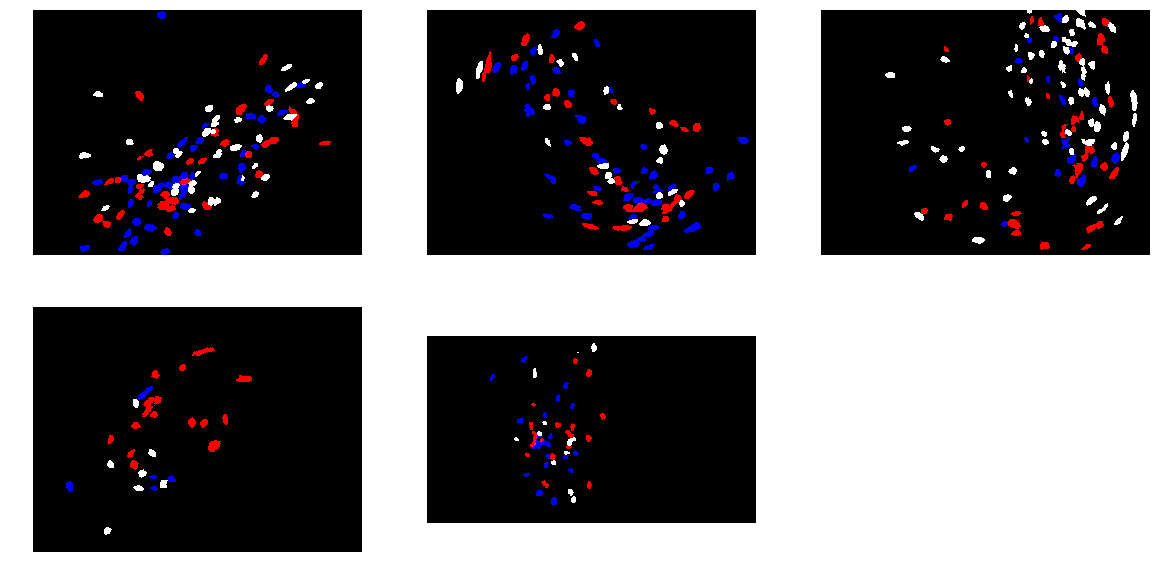

In [16]:
fig,ax=plt.subplots(2,3,figsize=(20,10))
for ii, foldername in enumerate(foldernames):
    session = data[foldername]['session']
    all_cells_image = make_cell_map(session, ax.flatten()[ii])
    ax.flatten()[ii].axis('off')
ax.flatten()[5].axis('off')

In [17]:
session = data[foldernames[3]]['session']

In [18]:
def get_distance(session, cell_0, cell_1):
    x0 = session.metrics.loc[cell_0]['overallCenterInPixelsX']
    y0 = session.metrics.loc[cell_0]['overallCenterInPixelsY']

    x1 = session.metrics.loc[cell_1]['overallCenterInPixelsX']
    y1 = session.metrics.loc[cell_1]['overallCenterInPixelsY']

    return np.sqrt((x1 - x0)**2 + (y1 - y0)**2)

In [19]:
dfs = []
for foldername in foldernames:
    session = data[foldername]['session']
    distances = xr.DataArray(
        np.zeros((len(session.filtered_cell_IDs), len(session.filtered_cell_IDs))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session.filtered_cell_IDs, 'cell_1': session.filtered_cell_IDs}
    )*np.nan

    both_significant = xr.DataArray(
        np.zeros((len(session.filtered_cell_IDs), len(session.filtered_cell_IDs))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session.filtered_cell_IDs, 'cell_1': session.filtered_cell_IDs}
    )*np.nan

    same_direction = xr.DataArray(
        np.zeros((len(session.filtered_cell_IDs), len(session.filtered_cell_IDs))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session.filtered_cell_IDs, 'cell_1': session.filtered_cell_IDs}
    )*np.nan

    direction = xr.DataArray(
        np.zeros((len(session.filtered_cell_IDs), len(session.filtered_cell_IDs))),
        dims=('cell_0','cell_1'),
        coords={'cell_0': session.filtered_cell_IDs, 'cell_1': session.filtered_cell_IDs}
    )*np.nan

    for row,cell_0 in enumerate(session.filtered_cell_IDs):
        print(cell_0, end='\r')
        for col,cell_1 in enumerate(session.filtered_cell_IDs):
            if row > col:
                distances.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = get_distance(session, cell_0, cell_1)

                c0_rs = session.responsiveness_summary.query('cell_id == @cell_0 and condition == "hit"').iloc[0]
                c1_rs = session.responsiveness_summary.query('cell_id == @cell_1 and condition == "hit"').iloc[0]
                both_significant.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = c0_rs['p-value_on_means'] <= significance_level and c1_rs['p-value_on_means'] <= significance_level
                same_direction.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = c0_rs['direction_of_effect_on_means'] == c1_rs['direction_of_effect_on_means'] 
                if c0_rs['direction_of_effect_on_means'] == c1_rs['direction_of_effect_on_means']:
                    direction.loc[dict(cell_0 = cell_0, cell_1 = cell_1)] = c0_rs['direction_of_effect_on_means'] 


    list_of_dicts = []
    locs = np.where(both_significant == 1)
    for x,y in zip(locs[0], locs[1]):
        list_of_dicts.append({
            'cell_0':str(both_significant[x,y].coords['cell_0'].values),
            'cell_1':str(both_significant[x,y].coords['cell_1'].values),
            'distance':float(distances[x,y].values),
            'same_direction':bool(same_direction[x,y].values),
            'direction':float(direction[x,y].values),
        })
    df = pd.DataFrame(list_of_dicts)
    dfs.append(df)
    print(stats.ttest_ind(df.query('same_direction == True')['distance'], df.query('same_direction == False')['distance']))
    
distance_df = pd.concat(dfs)    

Ttest_indResult(statistic=0.4239521824846178, pvalue=0.6716310720737699)
Ttest_indResult(statistic=0.5273795214990546, pvalue=0.5979700728505875)
Ttest_indResult(statistic=1.8330035445329065, pvalue=0.06701799393615585)
Ttest_indResult(statistic=-4.4535473929713065, pvalue=1.320587791846258e-05)
Ttest_indResult(statistic=0.08645608680176202, pvalue=0.9311186054977878)


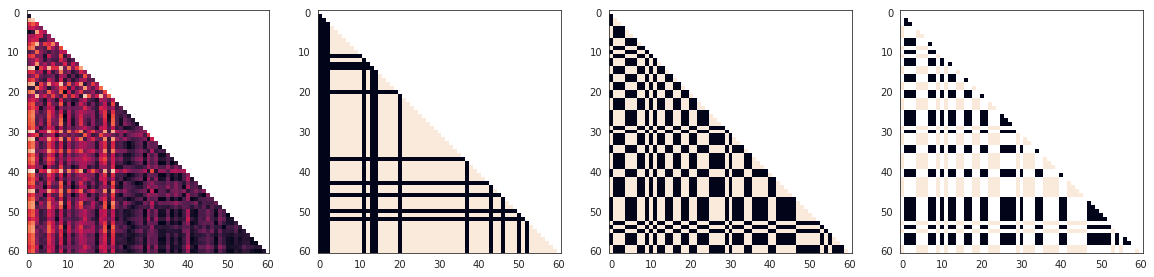

In [20]:
fig,ax=plt.subplots(1,4,figsize=(20,5))
ax[0].imshow(distances.values)
ax[1].imshow(both_significant.values)
ax[2].imshow(same_direction.values)
ax[3].imshow(direction.values)

In [21]:
print(stats.ttest_ind(distance_df.query('same_direction == True')['distance'], distance_df.query('same_direction == False')['distance']))

Ttest_indResult(statistic=1.4531502321623968, pvalue=0.14621806419610994)


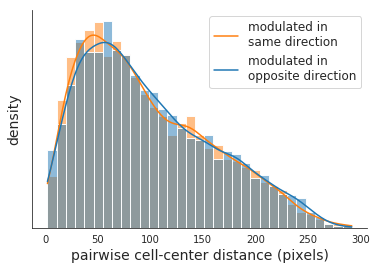

In [46]:
def distance_density_plot(ax=None):
    if ax is None:
        fig,ax=plt.subplots()
    sns.histplot(
        data=distance_df, 
        x="distance", 
        hue='same_direction',
        hue_order=[True,False],
        kde=True,
        stat='density',
        common_norm=False,
        ax=ax,
    )
    ax.legend(['modulated in\nsame direction','modulated in\nopposite direction'],fontsize=12)
    ax.set_xlabel('pairwise cell-center distance (pixels)',fontsize=14)
    ax.set_ylabel('density',fontsize=14)
    ax.set_yticklabels([])
    sns.despine()
distance_density_plot()

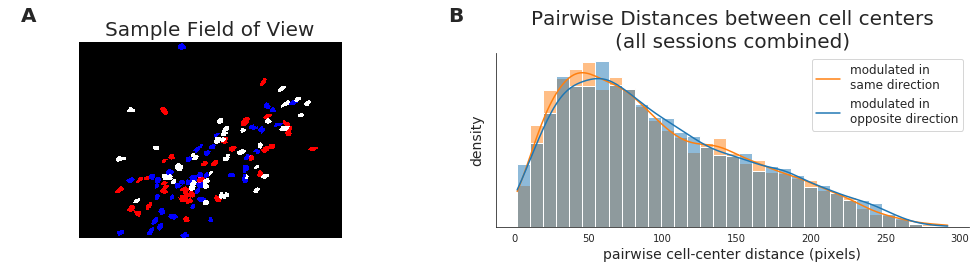

In [60]:
save_fig = True

figsize=(2*8.5,2*2)
figure_4 = plt.figure(figsize=figsize)
axes = {
    'A':plotting_utilities.placeAxesOnGrid(figure_4, xspan=[0.0,0.4], yspan=[0.1,1]),
    'B':plotting_utilities.placeAxesOnGrid(figure_4, xspan=[0.5,1], yspan=[0.15,0.95]),
}

all_cells_image = make_cell_map(data[foldernames[0]]['session'], ax=axes['A'])
axes['A'].set_title('Sample Field of View',fontsize=20)
distance_density_plot(ax=axes['B'])
axes['B'].set_title('Pairwise Distances between cell centers\n(all sessions combined)',fontsize=20)

# add labels
labels = [
    {'label_text':'A', 'xpos':0,   'ypos':0.00},
    {'label_text':'B', 'xpos':0.45, 'ypos':0.00},
]
for label in labels:
    plotting_utilities.add_label(
        figure_4,
        label_text = label['label_text'],
        xpos = label['xpos'],
        ypos = label['ypos'],
        fontsize=20,
        weight="bold"
    )

if save_fig:
    plotting_utilities.save_figure(figure_4, fname='figure_4', formats=['.png','.pdf'], size=figsize, dpi=500)

In [62]:
session = data[foldernames[0]]['session']

In [63]:
dir(session)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'behavior_core_data',
 'cell_images',
 'cellset',
 'database_id',
 'datapath',
 'determine_experiment_type',
 'detrend_trace',
 'event_dict',
 'experiment_type',
 'filenames',
 'filter_cells',
 'filtered_cell_IDs',
 'filtered_traces',
 'make_behavior_summary_plot',
 'measure_peaks',
 'metrics',
 'mouse_id',
 'movies',
 'repeat_roi_analysis',
 'responsiveness_data',
 'responsiveness_summary',
 'series_cs',
 'sync_data',
 'traces']

In [65]:
dir(session.repeat_roi_analysis)

['SSIM_matr',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'build_pairwise_cell_dataframe',
 'calculate_pairwise_matrices',
 'cell_ids',
 'cellset',
 'corr_matr',
 'dist_matr',
 'get_distance',
 'pairwise_cell_metrics',
 'plot',
 'plot_pairwise_matrices']

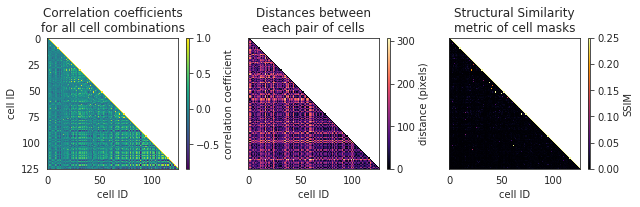

In [67]:
session.repeat_roi_analysis.plot_pairwise_matrices()

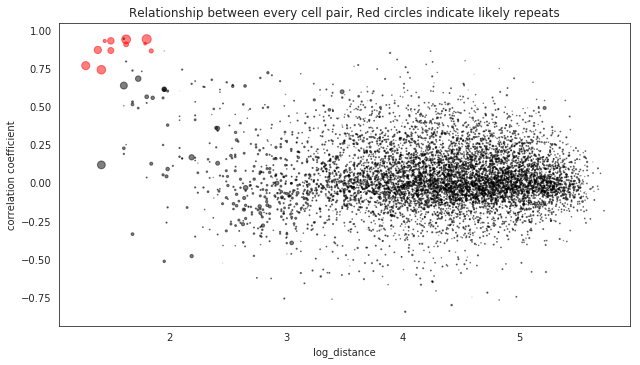

In [68]:
session.repeat_roi_analysis.plot()